In [1]:
import json
import pandas as pd

# Load your dataset (the JSON file you've provided)
with open('/content/new_data.json', 'r') as f:
    data = json.load(f)

# Flatten the dataset into a list of (query, intent) pairs
queries = []
intents = []

for item in data['intents']:
    intent = item['intent']
    for query in item['queries']:
        queries.append(query)
        intents.append(intent)

# Convert to a Pandas DataFrame for easy handling
df = pd.DataFrame({'query': queries, 'intent': intents})

# Check the first few rows
print(df.head())


                                           query       intent
0               Tell me about the Python course.  course_info
1              Tell me, about the Python course.  course_info
2  I am asking, Tell ME about the Python course.  course_info
3                Tell me about the Python course  course_info
4                 Tell me about the Java course.  course_info


In [4]:
from transformers import DistilBertTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch

# Initialize the tokenizer for DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the queries
tokens = tokenizer(
    list(df['query']),
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=128
)

# Encode the intent labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['intent'])

# Convert labels to a tensor
labels = torch.tensor(labels)

# Split the data into training and test sets, include input_ids and attention_mask
train_inputs, test_inputs, train_masks, test_masks, train_labels, test_labels = train_test_split(
    tokens['input_ids'], tokens['attention_mask'], labels, test_size=0.2, random_state=42
)

# Convert the data into a Dataset format
class IntentDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

# Create dataset objects for training and test sets
train_dataset = IntentDataset(train_inputs, train_masks, train_labels)
test_dataset = IntentDataset(test_inputs, test_masks, test_labels)


In [5]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

# Initialize the model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder.classes_))

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    num_train_epochs=3,              # Number of training epochs
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=64,   # Batch size for evaluation
    warmup_steps=500,                # Warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # The model to be trained
    args=training_args,                  # Training arguments
    train_dataset=train_dataset,         # Training dataset
    eval_dataset=test_dataset            # Evaluation dataset
)

# Train the model
trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,2.069900
20,2.081200
30,2.078800
40,2.076800
50,2.048400
60,2.032900
70,2.017800
80,1.961000
90,1.902100
100,1.812500


TrainOutput(global_step=132, training_loss=1.9085611484267495, metrics={'train_runtime': 376.4758, 'train_samples_per_second': 5.562, 'train_steps_per_second': 0.351, 'total_flos': 12462065453664.0, 'train_loss': 1.9085611484267495, 'epoch': 3.0})

In [6]:
# Evaluate the model on the test dataset
eval_results = trainer.evaluate()

# Print evaluation results
print(eval_results)


{'eval_loss': 1.350030541419983, 'eval_runtime': 9.5126, 'eval_samples_per_second': 18.397, 'eval_steps_per_second': 0.315, 'epoch': 3.0}


In [30]:
# Example input query
example_query = "Do you offer internship opportunities for students in the cloud computing program?"

# Tokenize the example query
tokens = tokenizer(
    example_query,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=128
)

# Set the model to evaluation mode
model.eval()

# Get the model's prediction
with torch.no_grad():
    outputs = model(**tokens)
    logits = outputs.logits
    predicted_class_id = logits.argmax(dim=-1).item()

# Decode the predicted label (intent)
predicted_intent = label_encoder.inverse_transform([predicted_class_id])

# Print the predicted intent
print(f"Predicted Intent for '{example_query}': {predicted_intent[0]}")


Predicted Intent for 'Do you offer internship opportunities for students in the cloud computing program?': placement_support


In [31]:
model.save_pretrained('./saved_model')
tokenizer.save_pretrained('./saved_model')


('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json')

In [33]:
# Zip the saved_model folder
!zip -r saved_model.zip ./saved_model


  adding: saved_model/ (stored 0%)
  adding: saved_model/vocab.txt (deflated 53%)
  adding: saved_model/tokenizer_config.json (deflated 75%)
  adding: saved_model/config.json (deflated 54%)
  adding: saved_model/model.safetensors (deflated 8%)
  adding: saved_model/special_tokens_map.json (deflated 42%)


In [34]:
from google.colab import files

# Download the zipped model folder
files.download('saved_model.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
import torch

# Save only the model's weights (state_dict) as a .pth file
torch.save(model.state_dict(), 'model.pth')


In [36]:
from google.colab import files

# Download the model.pth file to your local system
files.download('model.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
from sklearn.metrics import accuracy_score

# Create data loader for the test dataset
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

# Switch model to evaluation mode
model.eval()

predictions = []
true_labels = []

# Loop through batches of the test set
for batch in test_dataloader:
    # Move inputs and labels to GPU if available
    input_ids = batch['input_ids'].to('cpu')
    attention_mask = batch['attention_mask'].to('cpu')
    labels = batch['labels'].to('cpu')

    with torch.no_grad():
        # Perform forward pass (get predictions)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1).cpu().numpy()

    predictions.extend(preds)
    true_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8285714285714286


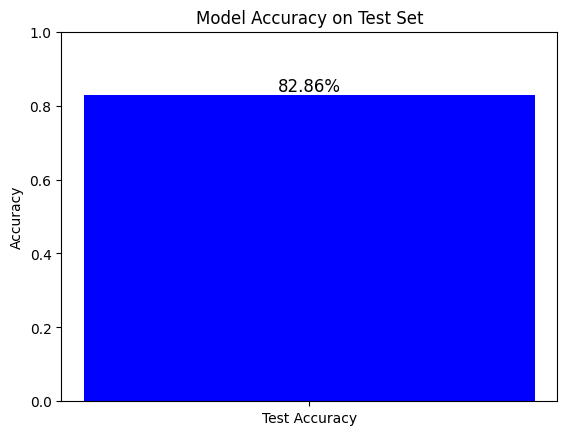

In [39]:
import matplotlib.pyplot as plt

# Final accuracy value
accuracy = 0.8286

# Plot the accuracy as a bar chart
plt.bar(['Test Accuracy'], [accuracy], color='blue')

# Add title and labels
plt.title('Model Accuracy on Test Set')
plt.ylabel('Accuracy')

# Display the accuracy value on the bar
for i, v in enumerate([accuracy]):
    plt.text(i, v + 0.01, f"{v:.2%}", ha='center', fontsize=12)

plt.ylim(0, 1)  # Set y-axis from 0 to 1 for percentage visualization
plt.show()


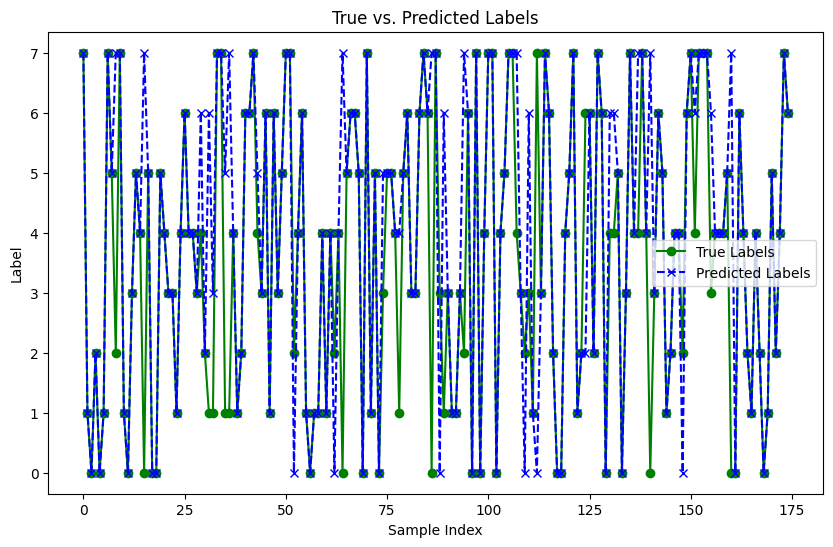

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Convert lists to numpy arrays for easier handling (if not already)
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot the true labels and predicted labels
plt.plot(true_labels, label="True Labels", color="green", linestyle="-", marker="o")
plt.plot(predictions, label="Predicted Labels", color="blue", linestyle="--", marker="x")

# Add labels and title
plt.title('True vs. Predicted Labels')
plt.xlabel('Sample Index')
plt.ylabel('Label')

# Display the legend
plt.legend()

# Show the plot
plt.show()


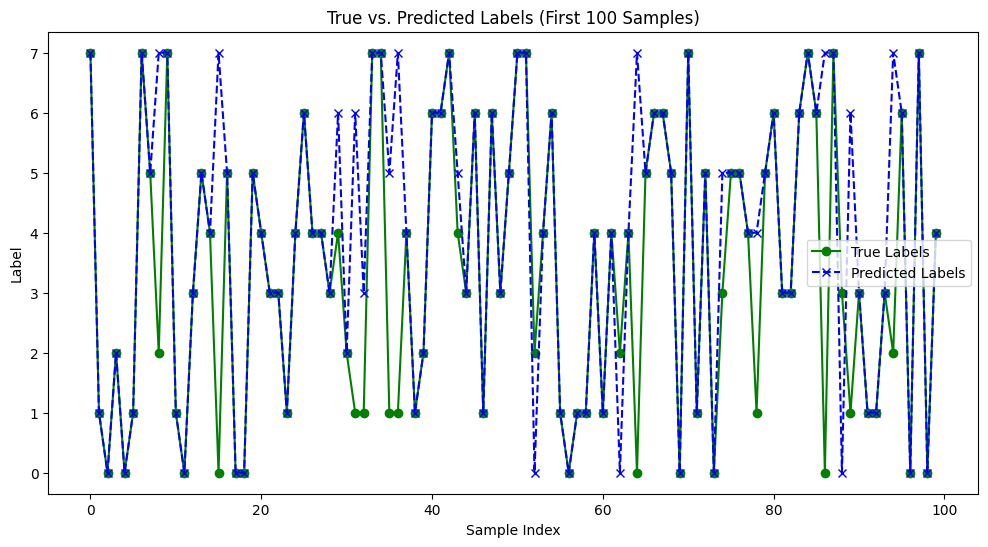

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Convert lists to numpy arrays for easier handling (if not already)
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Define the number of samples you want to plot
num_samples_to_plot = 100  # You can adjust this value

# Create a figure and axis
plt.figure(figsize=(12, 6))

# Plot the true labels and predicted labels for the subset
plt.plot(true_labels[:num_samples_to_plot], label="True Labels", color="green", linestyle="-", marker="o")
plt.plot(predictions[:num_samples_to_plot], label="Predicted Labels", color="blue", linestyle="--", marker="x")

# Add labels and title
plt.title(f'True vs. Predicted Labels (First {num_samples_to_plot} Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Label')

# Display the legend
plt.legend()

# Show the plot
plt.show()


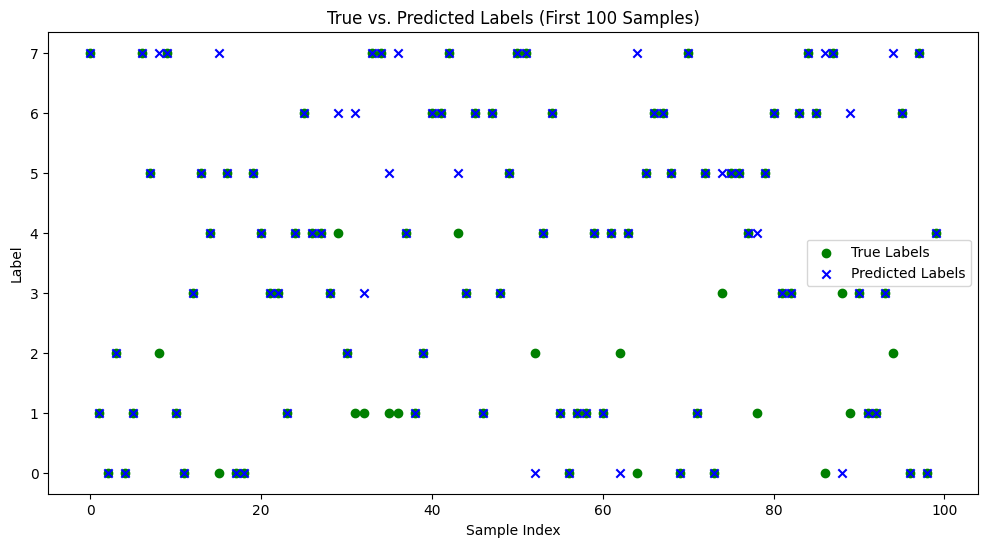

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Convert lists to numpy arrays (if not already)
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Define the number of samples to plot
num_samples_to_plot = 100  # Adjust as needed

# Create a figure
plt.figure(figsize=(12, 6))

# Plot true labels as green dots
plt.scatter(range(num_samples_to_plot), true_labels[:num_samples_to_plot], label="True Labels", color="green", marker="o")

# Plot predicted labels as blue crosses
plt.scatter(range(num_samples_to_plot), predictions[:num_samples_to_plot], label="Predicted Labels", color="blue", marker="x")

# Add labels and title
plt.title(f'True vs. Predicted Labels (First {num_samples_to_plot} Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Label')

# Display the legend
plt.legend()

# Show the plot
plt.show()
